# 房价预测案例

## Step 1: 检视源数据集

In [9]:
import numpy as np
import pandas as pd

#### 读入数据

* 一般来说源数据的index那一栏没什么用，我们可以用来作为我们pandas dataframe的index。这样之后要是检索起来也省事儿。

* 有人的地方就有鄙视链。跟知乎一样。Kaggle的也是个处处呵呵的危险地带。Kaggle上默认把数据放在*input*文件夹下。所以我们没事儿写个教程什么的，也可以依据这个convention来，显得自己很有逼格。。

In [10]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)

#### 检视源数据

In [11]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


这时候大概心里可以有数，哪些地方需要人为的处理一下，以做到源数据更加好被process。

## Step 2: 合并数据

这么做主要是为了用DF进行数据预处理的时候更加方便。等所有的需要的预处理进行完之后，我们再把他们分隔开。

首先，SalePrice作为我们的训练目标，只会出现在训练集中，不会在测试集中（要不然你测试什么？）。所以，我们先把*SalePrice*这一列给拿出来，不让它碍事儿。

我们先看一下*SalePrice*长什么样纸：

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BF7976E470>,
      dtype=object)

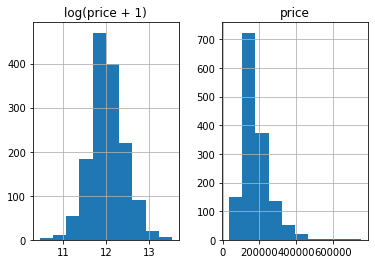

In [12]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

可见，label本身并不平滑。为了我们分类器的学习更加准确，我们会首先把label给“平滑化”（正态化）

这一步大部分同学会miss掉，导致自己的结果总是达不到一定标准。

这里我们使用最有逼格的log1p, 也就是 log(x+1)，避免了复值的问题。

记住哟，如果我们这里把数据都给平滑化了，那么最后算结果的时候，要记得把预测到的平滑数据给变回去。

按照“怎么来的怎么去”原则，log1p()就需要expm1(); 同理，log()就需要exp(), ... etc.

In [13]:
y_train = np.log1p(train_df.pop('SalePrice'))

然后我们把剩下的部分合并起来

In [14]:
all_df = pd.concat((train_df, test_df), axis=0)

此刻，我们可以看到all_df就是我们合在一起的DF

In [15]:
all_df.shape

(2919, 79)

而*y_train*则是*SalePrice*那一列

In [16]:
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

## Step 3: 变量转化

类似『特征工程』。就是把不方便处理或者不unify的数据给统一了。

#### 正确化变量属性

首先，我们注意到，*MSSubClass* 的值其实应该是一个category，

但是Pandas是不会懂这些事儿的。使用DF的时候，这类数字符号会被默认记成数字。

这种东西就很有误导性，我们需要把它变回成*string*

In [20]:
all_df['MSSubClass'].dtypes

dtype('O')

In [21]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

变成*str*以后，做个统计，就很清楚了

In [22]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

#### 把category的变量转变成numerical表达形式

当我们用numerical来表达categorical的时候，要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。于是我们可以用One-Hot的方法来表达category。

pandas自带的get_dummies方法，可以帮你一键做到One-Hot。

In [23]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


此刻*MSSubClass*被我们分成了12个column，每一个代表一个category。是就是1，不是就是0。

同理，我们把所有的category数据，都给One-Hot了

In [24]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


#### 处理好numerical变量

就算是numerical的变量，也还会有一些小问题。

比如，有一些数据是缺失的：

In [25]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

可以看到，缺失最多的column是LotFrontage

处理这些缺失的信息，得靠好好审题。一般来说，数据集的描述里会写的很清楚，这些缺失都代表着什么。当然，如果实在没有的话，也只能靠自己的『想当然』。。

在这里，我们用平均值来填满这些空缺。

In [26]:
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [27]:
all_dummy_df = all_dummy_df.fillna(mean_cols)

看看是不是没有空缺了？

In [28]:
all_dummy_df.isnull().sum().sum()

0

#### 标准化numerical数据

这一步并不是必要，但是得看你想要用的分类器是什么。一般来说，regression的分类器都比较傲娇，最好是把源数据给放在一个标准分布内。不要让数据间的差距太大。

这里，我们当然不需要把One-Hot的那些0/1数据给标准化。我们的目标应该是那些本来就是numerical的数据：

先来看看 哪些是numerical的：

In [29]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

计算标准分布：(X-X')/s

让我们的数据点更平滑，更便于计算。

注意：我们这里也是可以继续使用Log的，我只是给大家展示一下多种“使数据平滑”的办法。

In [30]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## Step 4: 建立模型

#### 把数据集分回 训练/测试集

In [31]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [32]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

#### Ridge Regression

用Ridge Regression模型来跑一遍看看。（对于多因子的数据集，这种模型可以方便的把所有的var都无脑的放进去）

In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

这一步不是很必要，只是把DF转化成Numpy Array，这跟Sklearn更加配

In [37]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

用Sklearn自带的cross validation方法来测试模型

In [38]:
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

存下所有的CV值，看看哪个alpha值更好（也就是『调参数』）

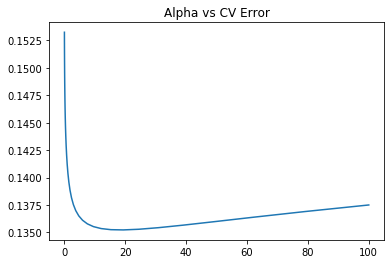

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

可见，大概alpha=10~20的时候，可以把score达到0.135左右。

#### Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

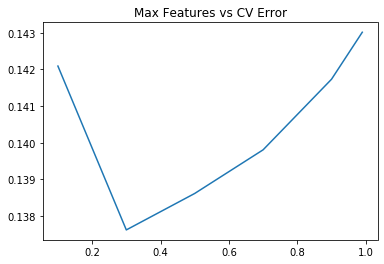

In [42]:
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error");

用RF的最优值达到了0.137

## Step 5: Ensemble

这里我们用一个Stacking的思维来汲取两种或者多种模型的优点

首先，我们把最好的parameter拿出来，做成我们最终的model

In [43]:
ridge = Ridge(alpha=15)
rf = RandomForestRegressor(n_estimators=500, max_features=.3)

In [44]:
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

上面提到了，因为最前面我们给label做了个log(1+x), 于是这里我们需要把predit的值给exp回去，并且减掉那个"1"

所以就是我们的expm1()函数。

In [45]:
y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

一个正经的Ensemble是把这群model的预测结果作为新的input，再做一次预测。这里我们简单的方法，就是直接『平均化』。

In [46]:
y_final = (y_ridge + y_rf) / 2

## Step 6: 提交结果

In [47]:
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': y_final})

我们的submission大概长这样：

In [48]:
submission_df.head(10)

,Id,SalePrice
0,1461,120200.963741
1,1462,151215.231228
2,1463,174950.025515
3,1464,189800.808226
4,1465,196451.434440
5,1466,175849.244530
6,1467,177008.405053
7,1468,169503.300330
8,1469,185020.194965
9,1470,122841.768823


走你~